In [7]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
# import nbimporter
from Functions import f_reg_scat_plt # pip install import_ipynb

# import sys
# sys.path.append("Functions")

# from f_scat_plt import f_scat_plt


pd.set_option('display.max_rows', None) # code to not truncate dataframe when it is displayed

In [14]:
# read in CSV to be analysed

df = pd.read_csv("Resources/Data_Clean_Cases.csv")

df.head()

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [3]:
# Generate list of dataframe of correlations
df_corr = df.corr() 

# Unstack and sort correlation from highest to lowest
correlation = df_corr.unstack().sort_values(ascending = False)

# Reset index to extract columns for renaming and change correlation value to R-squared value
correlation = correlation.reset_index() 
correlation = correlation.rename(columns={'level_0':'column1','level_1':'column2',0:'R_Square'})
correlation['R_Square'] = round(correlation['R_Square'] ** 2,6)

# Filter out values with R squared value of 1 where it is comparing the same column
correlation= correlation.loc[correlation['R_Square']!=1.0]

# Filter out columns where both colunms are indicating the same set of data
# For example 'people_fully_vaccinated_per_hundred' & 'total_vaccinations_per_hundred' are fundamentally the same data and correlation is bound to be high.
# The code works by checking for a string (eg.'vac') in both columns
# if both column contains the string it'll be filtered out of the analysis

list_of_string_to_check = ['vac','test', 'death', 'hosp', 'case']

for string in list_of_string_to_check: # Loop to iterate through the list_of_string_to_check
    for index, row in correlation.iterrows(): # Loop thorugh the rows in the dataframe
        
        # Set variables to 0
        x = 0 
        y = 0
        
        # Check for strings in each column and input 1 if it exists
        if row['column1'].find(string) >= 0:
            x = 1
        if row['column2'].find(string) >= 0:
            y = 1
        
        # Add previous variables together and if value is 2 then mark the row with the value 1 to be dropped later
        if x + y == 2:
            correlation.at[index, string] = 1
        else:
            correlation.at[index, string] = 0

# Create column to total marked rows to drop
correlation['total'] = correlation[list_of_string_to_check].sum(axis = 1)
# Filter out marked rows
correlation= correlation.loc[correlation['total']!=1.0]



# Filter out columns where one column indicate 'new' (eg. 'new_death') and the other indicate 'total' (eg. 'total_deaths')
# This is because there'll be no correlation between these 2 sets of data.
# The code works by checking for a string 'new' in one columns and 'total' in the other and vice versa
# If true then the row will be marked to be dropped.

# check for 'new' in column1 and 'total' in column 2
for index, row in correlation.iterrows():
    x = 0
    y = 0
    if row['column1'].find('new') >= 0:
        x = 1
    if row['column2'].find('total') >= 0:
        y = 1
    if x + y > 1:
        correlation.at[index, 'new_vs_total'] = 1
    else:
        correlation.at[index, 'new_vs_total'] = 0

# check for 'total' in column1 and 'new' in column 2
for index, row in correlation.iterrows():
    x = 0
    y = 0
    if row['column1'].find('total') >= 0:
        x = 1
    if row['column2'].find('new') >= 0:
        y = 1
    if x + y > 1:
        correlation.at[index, 'total_vs_new'] = 1
    else:
        correlation.at[index, 'total_vs_new'] = 0

# Total the 2 columns and mark it to be dropped
col_list = ['total_vs_new','new_vs_total']
correlation['total_2'] = correlation[col_list].sum(axis = 1)

# Filter out the above condition
correlation= correlation.loc[correlation['total_2']!=1.0]

# Filter out duplication
correlation_drop_dup = correlation.drop_duplicates(subset=['R_Square']) # Drop duplicated R_square value because it is the same data as the line above just flipped

# Summarise the total rows of data
print(f"There are {len(correlation_drop_dup['column1'])} rows of data")

# Delete the rest of the colunmns used for filtering
correlation_drop_dup = correlation_drop_dup[['column1','column2','R_Square']]
correlation = correlation[['column1','column2','R_Square']]
correlation_drop_dup

There are 1540 rows of data


,column1,column2,R_Square
61,aged_70_older,aged_65_older,0.989745
73,icu_patients,weekly_hosp_admissions,0.946108
75,new_cases_smoothed,weekly_hosp_admissions,0.940969
79,icu_patients,hosp_patients,0.926915
83,total_tests,total_cases,0.918593
87,icu_patients,new_cases_smoothed,0.906019
93,new_deaths_smoothed,hosp_patients,0.870675
95,new_cases_smoothed,hosp_patients,0.868068
97,total_deaths,total_cases,0.864504
99,total_deaths,excess_mortality_cumulative_absolute,0.856133


In [4]:
column_name = 'handwashing_facilities'

filter_corr_df = correlation.loc[correlation['column1']==column_name]

filter_corr_df

,column1,column2,R_Square
155,handwashing_facilities,human_development_index,0.700882
167,handwashing_facilities,life_expectancy,0.679557
193,handwashing_facilities,median_age,0.618122
357,handwashing_facilities,gdp_per_capita,0.431198
391,handwashing_facilities,aged_65_older,0.411024
397,handwashing_facilities,aged_70_older,0.406065
444,handwashing_facilities,icu_patients_per_million,0.361841
475,handwashing_facilities,diabetes_prevalence,0.307727
538,handwashing_facilities,icu_patients,0.243838
566,handwashing_facilities,hospital_beds_per_thousand,0.199396


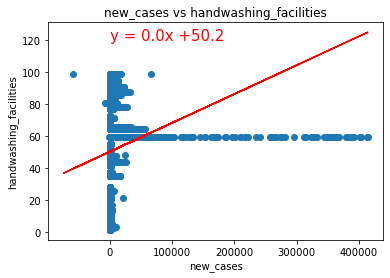

The r-value is: 0.00357


In [16]:
# Test function

col1 = 'new_cases'
col2 = 'handwashing_facilities'
x_pos_ann = 0
y_pos_ann = 120

f_reg_scat_plt.f_reg_scat_plt(df,col1,col2,x_pos_ann,y_pos_ann)

# Hypothesis/Notes
### 1. total_tests vs total_cases (0.918593) 
- Can show the amount of proactive tests completed
- More proactive test can then be linked to human development index??
- Proactiveness then can be link to vaccination rates??

### 2. 'stringency_index' 
- Government Response Stringency Index: composite measure based on 9 response indicators including school closures, workplace closures, and travel bans, rescaled to a value from 0 to 100 (100 = strictest response)
- Highest correlation is 0.160616 with 'icu_patients_per_million' might have better use for later.

### 3. total_tests vs total_vaccinations (0.713544) vs people_fully_vaccinated (0.746452)
- Correlation between uptake of vaccincations are higher where there are more tests (i.e. more resources for test or people more willing to test)

### 4. new_deaths vs icu_patients (0.759243) vs hosp_patients (0.784402)
- will indicate the reacting of a country on how well the country is coping with putting people infected with Covid into the ICU/hospital

### 5. human_development_index vs life_expectancy (0.839406)
- Not COVID related, but will indicate that a better developed country will have a higher life_expectancy